## Import libraries

In [ ]:
#!pip install nvidia-modulus

In [1]:
# Required libraries
import os
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.profiler
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torch.cuda.amp import autocast
import torch_geometric
import torch_geometric.nn as geom_nn
from torch_geometric.nn import (
    MessagePassing,
    GCNConv,
    global_mean_pool as gap,
    global_max_pool as gmp,
)
from torch_geometric.data import Data, Dataset, DataLoader
from physicsnemo.models.fno import FNO
#from modulus.models.fno import FNO
# Device setup
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

/lustre/env/miniconda3/envs/NeurOCAST-4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


##  Configuration

In [2]:
train_size = 0.85
val_size = 1-train_size
#test_size = 0.15
Batch_size = 8
learning_rate = 1e-4
weight_decay= 1e-5
epochs = 200
#num_workers = 2

## Preprocess the data

In [3]:
# Load input and output
x_npy = np.load('/lustre/gpu-lustre/code/Input/x_array_4_years_utc.npy')
y_npy = np.load('/lustre/gpu-lustre/code/Input/y_array_4_years_utc.npy')
time_npy = np.load('/lustre/gpu-lustre/code/Input/time_array_4_years_utc.npy')
#edge_index = torch.load("/lustre/code/BiasCorrection/Codes/edge_index.pt")


X = torch.tensor(x_npy)
Y = torch.tensor(y_npy)

X.shape, Y.shape, time_npy.shape

(torch.Size([5328, 20, 8, 186]), torch.Size([5328, 20, 186]), (5328, 186))

#### Separate 17 stations for training

In [4]:
# keep station 2, 6, and 14 out for the test

X_17 = X[:,[i for i in range(X.size(1)) if i not in [1, 5, 13]], :,:]
Y_17 = Y[:,[i for i in range(Y.size(1)) if i not in [1, 5, 13]], :]

X_17.shape, Y_17.shape



(torch.Size([5328, 17, 8, 186]), torch.Size([5328, 17, 186]))

#### Use 2021, 2022, 2023 for training and validation

In [5]:
time_npy

array([['2021-02-28T19:00:00.000000000', '2021-02-28T20:00:00.000000000',
        '2021-02-28T21:00:00.000000000', ...,
        '2021-03-08T10:00:00.000000000', '2021-03-08T11:00:00.000000000',
        '2021-03-08T12:00:00.000000000'],
       ['2021-03-01T01:00:00.000000000', '2021-03-01T02:00:00.000000000',
        '2021-03-01T03:00:00.000000000', ...,
        '2021-03-08T16:00:00.000000000', '2021-03-08T17:00:00.000000000',
        '2021-03-08T18:00:00.000000000'],
       ['2021-03-01T07:00:00.000000000', '2021-03-01T08:00:00.000000000',
        '2021-03-01T09:00:00.000000000', ...,
        '2021-03-08T22:00:00.000000000', '2021-03-08T23:00:00.000000000',
        '2021-03-09T00:00:00.000000000'],
       ...,
       ['2024-10-22T01:00:00.000000000', '2024-10-22T02:00:00.000000000',
        '2024-10-22T03:00:00.000000000', ...,
        '2024-10-29T16:00:00.000000000', '2024-10-29T17:00:00.000000000',
        '2024-10-29T18:00:00.000000000'],
       ['2024-10-22T07:00:00.000000000', '20

In [6]:
# Find the index of the first sub-array that contains an element starting with "2024"
time_npy_str = time_npy.astype(str)
index = next(i for i, row in enumerate(time_npy_str) if np.any(np.char.startswith(row, "2024")))

print(index)

4114


In [7]:
X_17_2021_2022_2023 = X_17[:4113, :,:,:]
Y_17_2021_2022_2023 = Y_17[:4113, :,:]
time_npy_2021_2022_2023 = time_npy[:4113,:]

X_17_2021_2022_2023.shape,   Y_17_2021_2022_2023.shape,  time_npy_2021_2022_2023.shape

(torch.Size([4113, 17, 8, 186]), torch.Size([4113, 17, 186]), (4113, 186))

#### Remove nans from the analysis

In [8]:


# Find indices of samples in x that contain any NaN values
nan_indices = torch.isnan(X_17_2021_2022_2023).any(dim=(1, 2, 3)).nonzero(as_tuple=True)[0]

X_17_2021_2022_2023_cleaned_x = X_17_2021_2022_2023[[i for i in range(X_17_2021_2022_2023.size(0)) if i not in nan_indices],:,:,:]
Y_17_2021_2022_2023_cleaned_x = Y_17_2021_2022_2023[[i for i in range(X_17_2021_2022_2023.size(0)) if i not in nan_indices],:,:]

time_npy_2021_2022_2023_cleaned_x = time_npy_2021_2022_2023 [[i for i in range(X_17_2021_2022_2023.size(0)) if i not in nan_indices],:]

# Find indices of samples in x that contain any NaN values
nan_indices_y = torch.isnan(Y_17_2021_2022_2023_cleaned_x).any(dim=(1, 2)).nonzero(as_tuple=True)[0]

X_17_2021_2022_2023_cleaned_y = X_17_2021_2022_2023_cleaned_x[[i for i in range(Y_17_2021_2022_2023_cleaned_x.size(0)) if i not in nan_indices_y],:,:,:]
Y_17_2021_2022_2023_cleaned_y = Y_17_2021_2022_2023_cleaned_x[[i for i in range(Y_17_2021_2022_2023_cleaned_x.size(0)) if i not in nan_indices_y],:,:]

time_npy_2021_2022_2023_cleaned_y = time_npy_2021_2022_2023_cleaned_x [[i for i in range(Y_17_2021_2022_2023_cleaned_x.size(0)) if i not in nan_indices_y],:]

X_17_2021_2022_2023_cleaned_y.shape,   Y_17_2021_2022_2023_cleaned_y.shape,  time_npy_2021_2022_2023_cleaned_y.shape

(torch.Size([2645, 17, 8, 186]), torch.Size([2645, 17, 186]), (2645, 186))

#### Define the edge index for 17 stations

In [9]:
center = (-70.83, 42.24) 
x_min, y_min = center[0] - 5, center[1] - 2

station_convert = []

for i in range(17):
    station = [(float(X_17_2021_2022_2023_cleaned_y[0,i,7,0])- x_min)/2, (float(X_17_2021_2022_2023_cleaned_y[0,i,6,0])- y_min)/2]
    station_convert.append(station)
station_convert = torch.from_numpy(np.array(station_convert)).float()

    # generate edge_index
row_a=[]
row_b=[]  
row_ix=[]
row_iy=[]
row_jx=[]
row_jy=[]
for i in range(17):
    for j in range(17):
        row_a.append(i)
        row_b.append(j)
        row_ix.append(station_convert[i,0])
        row_iy.append(station_convert[i,1])
        row_jx.append(station_convert[j,0])
        row_jy.append(station_convert[j,1])

edge_index=[row_a,row_b,row_ix,row_iy,row_jx,row_jy]
edge_index = torch.from_numpy(np.array(edge_index)).float().to(device)
edge_index.shape

torch.Size([6, 289])

#### Define Training and validation data and create dataloader for them

In [32]:
# Step 1: Split the data

# Determine the indices for each split
num_samples = X_17_2021_2022_2023_cleaned_y.shape[0]  


# Generate shuffled indices
shuffled_indices = np.random.permutation(num_samples)


# Shuffle X and Y using the shuffled indices
X_17_2021_2022_2023_cleaned_y = X_17_2021_2022_2023_cleaned_y[shuffled_indices]
Y_17_2021_2022_2023_cleaned_y = Y_17_2021_2022_2023_cleaned_y[shuffled_indices]


train_end = int(train_size * num_samples)

# Split the data
x_train0 = X_17_2021_2022_2023_cleaned_y[:train_end,:,:,:].numpy()
y_train0 = Y_17_2021_2022_2023_cleaned_y[:train_end,:,:].numpy()

x_val0= X_17_2021_2022_2023_cleaned_y[train_end:,:,:,:].numpy()
y_val0 = Y_17_2021_2022_2023_cleaned_y[train_end:,:,:].numpy()

# Step 2: Normlaize the data using train data
x_train0_normalized = np.empty([x_train0.shape[0],x_train0.shape[1], x_train0.shape[2], x_train0.shape[3]], dtype=float)

for d in range(x_train0.shape[2]):
   x_mean, x_std = x_train0[:,:,d,:].mean(), x_train0[:,:,d,:].std()
   x_train0_normalized[:,:,d,:] = (x_train0[:,:,d,:] - x_mean)/x_std
x_train = torch.tensor(x_train0_normalized, dtype = torch.float32)

x_val0_normalized = np.empty([x_val0.shape[0], x_val0.shape[1], x_val0.shape[2], x_val0.shape[3]], dtype=float)

for d in range(x_train0.shape[2]):
   x_mean, x_std = x_train0[:,:,d,:].mean(), x_train0[:,:,d,:].std()
   x_val0_normalized[:,:,d,:] = (x_val0[:,:,d,:] - x_mean)/x_std
x_val = torch.tensor(x_val0_normalized, dtype = torch.float32)


y_train0_mean, y_train0_std = y_train0.mean(), y_train0.std()

y_train0_normalized = y_train0
# - y_train0_mean)/y_train0_std
y_train = torch.tensor(y_train0_normalized, dtype = torch.float32)

y_val0_normalized = y_val0
#y_val0_normalized = (y_val0 - y_train0_mean)/y_train0_std
y_val = torch.tensor(y_val0_normalized, dtype = torch.float32)

# Step 3: Generate graph data for each set
def generate_data(x_tensor, y_tensor,edge_index, num_graphs, num_nodes, num_features):
    data_list = []
    for i in range(num_graphs):
        x = x_tensor[i, :, :, :]  
        y = y_tensor[i, :, :]  
        edge_index = edge_index
        # Create the graph data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

    return data_list
from torch_geometric.data import DataLoader, Batch

# Generate graph data for each set
train_data = generate_data(x_train, y_train, edge_index, num_graphs=train_end, num_nodes=17, num_features=8)
val_data = generate_data(x_val, y_val, edge_index,  num_graphs=num_samples-train_end, num_nodes=17, num_features=8)


# Check data shapes 
print(f"Train data: {len(train_data)} graphs")
print(f"Validation data: {len(val_data)} graphs")

# Step 4: Create DataLoader for each dataset
train_loader = DataLoader(train_data, batch_size=Batch_size, shuffle=True, collate_fn=torch_geometric.data.Batch.from_data_list)
val_loader = DataLoader(val_data, batch_size=Batch_size, shuffle=False, collate_fn=torch_geometric.data.Batch.from_data_list)



Train data: 2248 graphs
Validation data: 397 graphs


/lustre/env/miniconda3/envs/NeurOCAST-4/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Define the model

In [51]:
from neurocast import NeurOCAST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeurOCAST(
    input_channels=8,
    output_channels=1,
    base_width=48,
    base_modes=24,
    num_layers=3,
    width_scale=[1.0, 2, 0.5],
    mode_scale=[1, 0.5, 2],
    resample_strategy=[0.7, 0.5, 2.5],
    padding=10
).to(device)


## Train the model

In [52]:
# Device
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


loss_module = torch.nn.MSELoss()

# AMP GradScaler
scaler = GradScaler()

for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    
    total_loss = 0.0
    for data in train_loader:
        data = data.to(device)
        
        optimizer.zero_grad()

        with autocast(enabled=True, dtype=torch.float16):

            data.edge_index = torch.tensor(data.edge_index)  
            output = model(
                data.x, 
                data.edge_index[:2, :],   
                data.edge_index[2:, :]    
            )
            loss = loss_module(output, data.y)
        total_loss += loss.item()     

        # scaled backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            with autocast():
                data.edge_index = torch.tensor(data.edge_index)  
                output = model(
                    data.x, 
                    data.edge_index[:2, :],
                    data.edge_index[2:, :]
                )
                loss = loss_module(output, data.y)
            val_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss   = val_loss / len(val_loader)



    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Time: {epoch_time:.2f}s")

torch.save(model.state_dict(), "NeurOCAST_model.pth")



/tmp/ipykernel_4354/2411203380.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_4354/2411203380.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True, dtype=torch.float16):
/tmp/ipykernel_4354/2411203380.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.edge_index = torch.tensor(data.edge_index)
/tmp/ipykernel_4354/2411203380.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_4354/2411203380.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clo

Epoch 1/200 | Train Loss: 0.0508 | Val Loss: 0.0384 | Time: 19.42s
Epoch 2/200 | Train Loss: 0.0300 | Val Loss: 0.0252 | Time: 18.50s
Epoch 3/200 | Train Loss: 0.0233 | Val Loss: 0.0232 | Time: 18.44s
Epoch 4/200 | Train Loss: 0.0217 | Val Loss: 0.0214 | Time: 18.40s
Epoch 5/200 | Train Loss: 0.0203 | Val Loss: 0.0213 | Time: 18.43s
Epoch 6/200 | Train Loss: 0.0192 | Val Loss: 0.0192 | Time: 18.45s
Epoch 7/200 | Train Loss: 0.0182 | Val Loss: 0.0186 | Time: 18.40s
Epoch 8/200 | Train Loss: 0.0177 | Val Loss: 0.0178 | Time: 18.37s
Epoch 9/200 | Train Loss: 0.0172 | Val Loss: 0.0175 | Time: 18.50s
Epoch 10/200 | Train Loss: 0.0165 | Val Loss: 0.0169 | Time: 18.49s
Epoch 11/200 | Train Loss: 0.0159 | Val Loss: 0.0168 | Time: 18.35s
Epoch 12/200 | Train Loss: 0.0156 | Val Loss: 0.0163 | Time: 18.50s
Epoch 13/200 | Train Loss: 0.0150 | Val Loss: 0.0157 | Time: 18.42s
Epoch 14/200 | Train Loss: 0.0147 | Val Loss: 0.0163 | Time: 19.23s
Epoch 15/200 | Train Loss: 0.0145 | Val Loss: 0.0157 | Ti


### Preprocess test data


In [69]:
# Using the index of 2024

X_20_2024 = X[index:, :,:,:]
Y_20_2024 = Y[index:, :,:]
time_npy_2024 = time_npy[index:,:]
X_20_2024.shape, Y_20_2024.shape, time_npy_2024.shape


(torch.Size([1214, 20, 8, 186]), torch.Size([1214, 20, 186]), (1214, 186))

In [70]:
# remove nans from the analysis

# Find indices of samples in x that contain any NaN values
nan_indices_X_20_2024 = torch.isnan(X_20_2024).any(dim=(1, 2, 3)).nonzero(as_tuple=True)[0]

X_20_2024_cleaned_x = X_20_2024[[i for i in range(X_20_2024.size(0)) if i not in nan_indices_X_20_2024],:,:,:]
Y_20_2024_cleaned_x = Y_20_2024[[i for i in range(X_20_2024.size(0)) if i not in nan_indices_X_20_2024],:,:]

time_npy_2024_cleaned_x = time_npy_2024 [[i for i in range(X_20_2024.size(0)) if i not in nan_indices_X_20_2024],:]

nan_indices_Y_20_2024 = torch.isnan(Y_20_2024_cleaned_x).any(dim=(1, 2)).nonzero(as_tuple=True)[0]

X_20_2024_cleaned_Y = X_20_2024_cleaned_x[[i for i in range(Y_20_2024_cleaned_x.size(0)) if i not in nan_indices_Y_20_2024],:,:,:]
Y_20_2024_cleaned_Y = Y_20_2024_cleaned_x[[i for i in range(X_20_2024_cleaned_x.size(0)) if i not in nan_indices_Y_20_2024],:,:]

time_npy_2024_cleaned_Y = time_npy_2024_cleaned_x[[i for i in range(X_20_2024_cleaned_x.size(0)) if i not in nan_indices_Y_20_2024],:]




### Defining edge_index for 20 stations




In [71]:
center = (-70.83, 42.24) 
x_min, y_min = center[0] - 5, center[1] - 2

station_convert = []

for i in range(20):
    station = [(float(X_20_2024_cleaned_Y[0,i,7,0])- x_min)/2, (float(X_20_2024_cleaned_Y[0,i,6,0])- y_min)/2]
    station_convert.append(station)
station_convert = torch.from_numpy(np.array(station_convert)).float()

    # generate edge_index
row_a=[]
row_b=[]  
row_ix=[]
row_iy=[]
row_jx=[]
row_jy=[]
for i in range(20):
    for j in range(20):
        row_a.append(i)
        row_b.append(j)
        row_ix.append(station_convert[i,0])
        row_iy.append(station_convert[i,1])
        row_jx.append(station_convert[j,0])
        row_jy.append(station_convert[j,1])

edge_index_20=[row_a,row_b,row_ix,row_iy,row_jx,row_jy]
edge_index_20 = torch.from_numpy(np.array(edge_index_20)).float().to(device)
edge_index_20.shape

torch.Size([6, 400])

### Define Testing data and create dataloader for that

In [72]:

# Normlaize the data using train data
x_test0_normalized = np.empty([X_20_2024_cleaned_Y.shape[0], X_20_2024_cleaned_Y.shape[1], X_20_2024_cleaned_Y.shape[2], X_20_2024_cleaned_Y.shape[3]], dtype=float)

for d in range(x_train0.shape[2]):
   x_mean, x_std = x_train0[:,:,d,:].mean(), x_train0[:,:,d,:].std()
   x_test0_normalized[:,:,d,:] = (X_20_2024_cleaned_Y[:,:,d,:] - x_mean)/x_std
x_test = torch.tensor(x_test0_normalized, dtype = torch.float32)


y_train0_mean, y_train0_std = y_train0.mean(), y_train0.std()

y_test0_normalized = Y_20_2024_cleaned_Y
#y_test0_normalized = (Y_20_2024_cleaned_Y - y_train0_mean)/y_train0_std
y_test = torch.tensor(y_test0_normalized, dtype = torch.float32)

# Generate graph data for each set
def generate_data(x_tensor, y_tensor,edge_index, num_graphs, num_nodes, num_features):
    data_list = []
    for i in range(num_graphs):
        x = x_tensor[i, :, :, :]  
        y = y_tensor[i, :, :]  
        edge_index = edge_index
        # Create the graph data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

    return data_list
from torch_geometric.data import DataLoader, Batch

# Generate graph data for each set
test_data = generate_data(x_test, y_test, edge_index_20, num_graphs=x_test.shape[0], num_nodes=20, num_features=8)


# Check data shapes 
print(f"Test data: {len(test_data)} graphs")

# Create DataLoader for each dataset
test_loader = DataLoader(test_data, batch_size=Batch_size, shuffle=False, collate_fn=torch_geometric.data.Batch.from_data_list)



/tmp/ipykernel_4354/3444805894.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_test0_normalized[:,:,d,:] = (X_20_2024_cleaned_Y[:,:,d,:] - x_mean)/x_std


Test data: 827 graphs


/tmp/ipykernel_4354/3444805894.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test0_normalized, dtype = torch.float32)


## Model evaluation

In [73]:
# Instantiate the model
model = NeurOCAST(
    input_channels=8,
    output_channels=1,
    base_width=48,
    base_modes=24,
    num_layers=3,
    width_scale=[1.0, 2, 0.5],
    mode_scale=[1, 0.5, 2],
    resample_strategy=[0.7, 0.5, 2],
    padding=10
).to(device)


# Load the saved model weights
model.load_state_dict(torch.load("NeurOCAST_model.pth"))


def eval_model(model, data_loader):
    model.eval()  # Set model to eval mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for data in test_loader:
            # Send data to device (GPU/CPU)
            data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            #data = data.to(device)


            # Normalize x and y
            #data.x = normalize_x(data.x)  # Normalize per feature/channel separately
            #data.y = normalize_y(data.y)  # Normalize target values per graph
            # Forward pass to get predictions
            preds = model(data.x, data.edge_index[:2,:], data.edge_index[2:,:])  # Assuming model returns the predictions
            #preds = preds.squeeze(dim=1)
            all_preds.append(preds)
            all_targets.append(data.y)

    # Concatenate all predictions and true targets into one tensor
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Calculate MSE between all predictions and true targets
    #mse_loss = F.mse_loss(all_preds, all_targets)
    mse_loss = loss_module(all_preds, all_targets)
    return mse_loss, all_preds, all_targets

In [74]:
mlp_result = eval_model(model, test_loader)
mlp_result

(tensor(0.0162, device='cuda:0'),
 tensor([[-0.4556, -0.5329, -0.5500,  ...,  0.0935,  0.0796, -0.0077],
         [-0.3361, -0.3729, -0.3723,  ...,  0.0687,  0.0672,  0.0175],
         [-0.4870, -0.5827, -0.6087,  ...,  0.0038,  0.0117, -0.0578],
         ...,
         [-0.3420, -0.3167, -0.2765,  ..., -0.1984, -0.2303, -0.3009],
         [-0.1075, -0.0695, -0.0450,  ..., -0.2469, -0.2366, -0.2010],
         [-0.3658, -0.3236, -0.2837,  ..., -0.2543, -0.3158, -0.4078]],
        device='cuda:0'),
 tensor([[-0.2950, -0.4250, -0.4759,  ...,  0.1809,  0.1948,  0.0578],
         [ 0.2475, -0.0944, -0.4866,  ...,  0.3209,  0.3803,  0.3638],
         [-0.2825, -0.4839, -0.6153,  ...,  0.1383,  0.1376,  0.0510],
         ...,
         [-0.3004, -0.2600, -0.2499,  ..., -0.3487, -0.3589, -0.4262],
         [-0.2807, -0.2095, -0.1379,  ..., -0.3610, -0.3851, -0.3893],
         [-0.3199, -0.2815, -0.2521,  ..., -0.4218, -0.4504, -0.5108]],
        device='cuda:0'))

In [75]:
mlp_result[0]

tensor(0.0162, device='cuda:0')

In [76]:
mlp_result[1].shape

torch.Size([16540, 186])

## Visulization

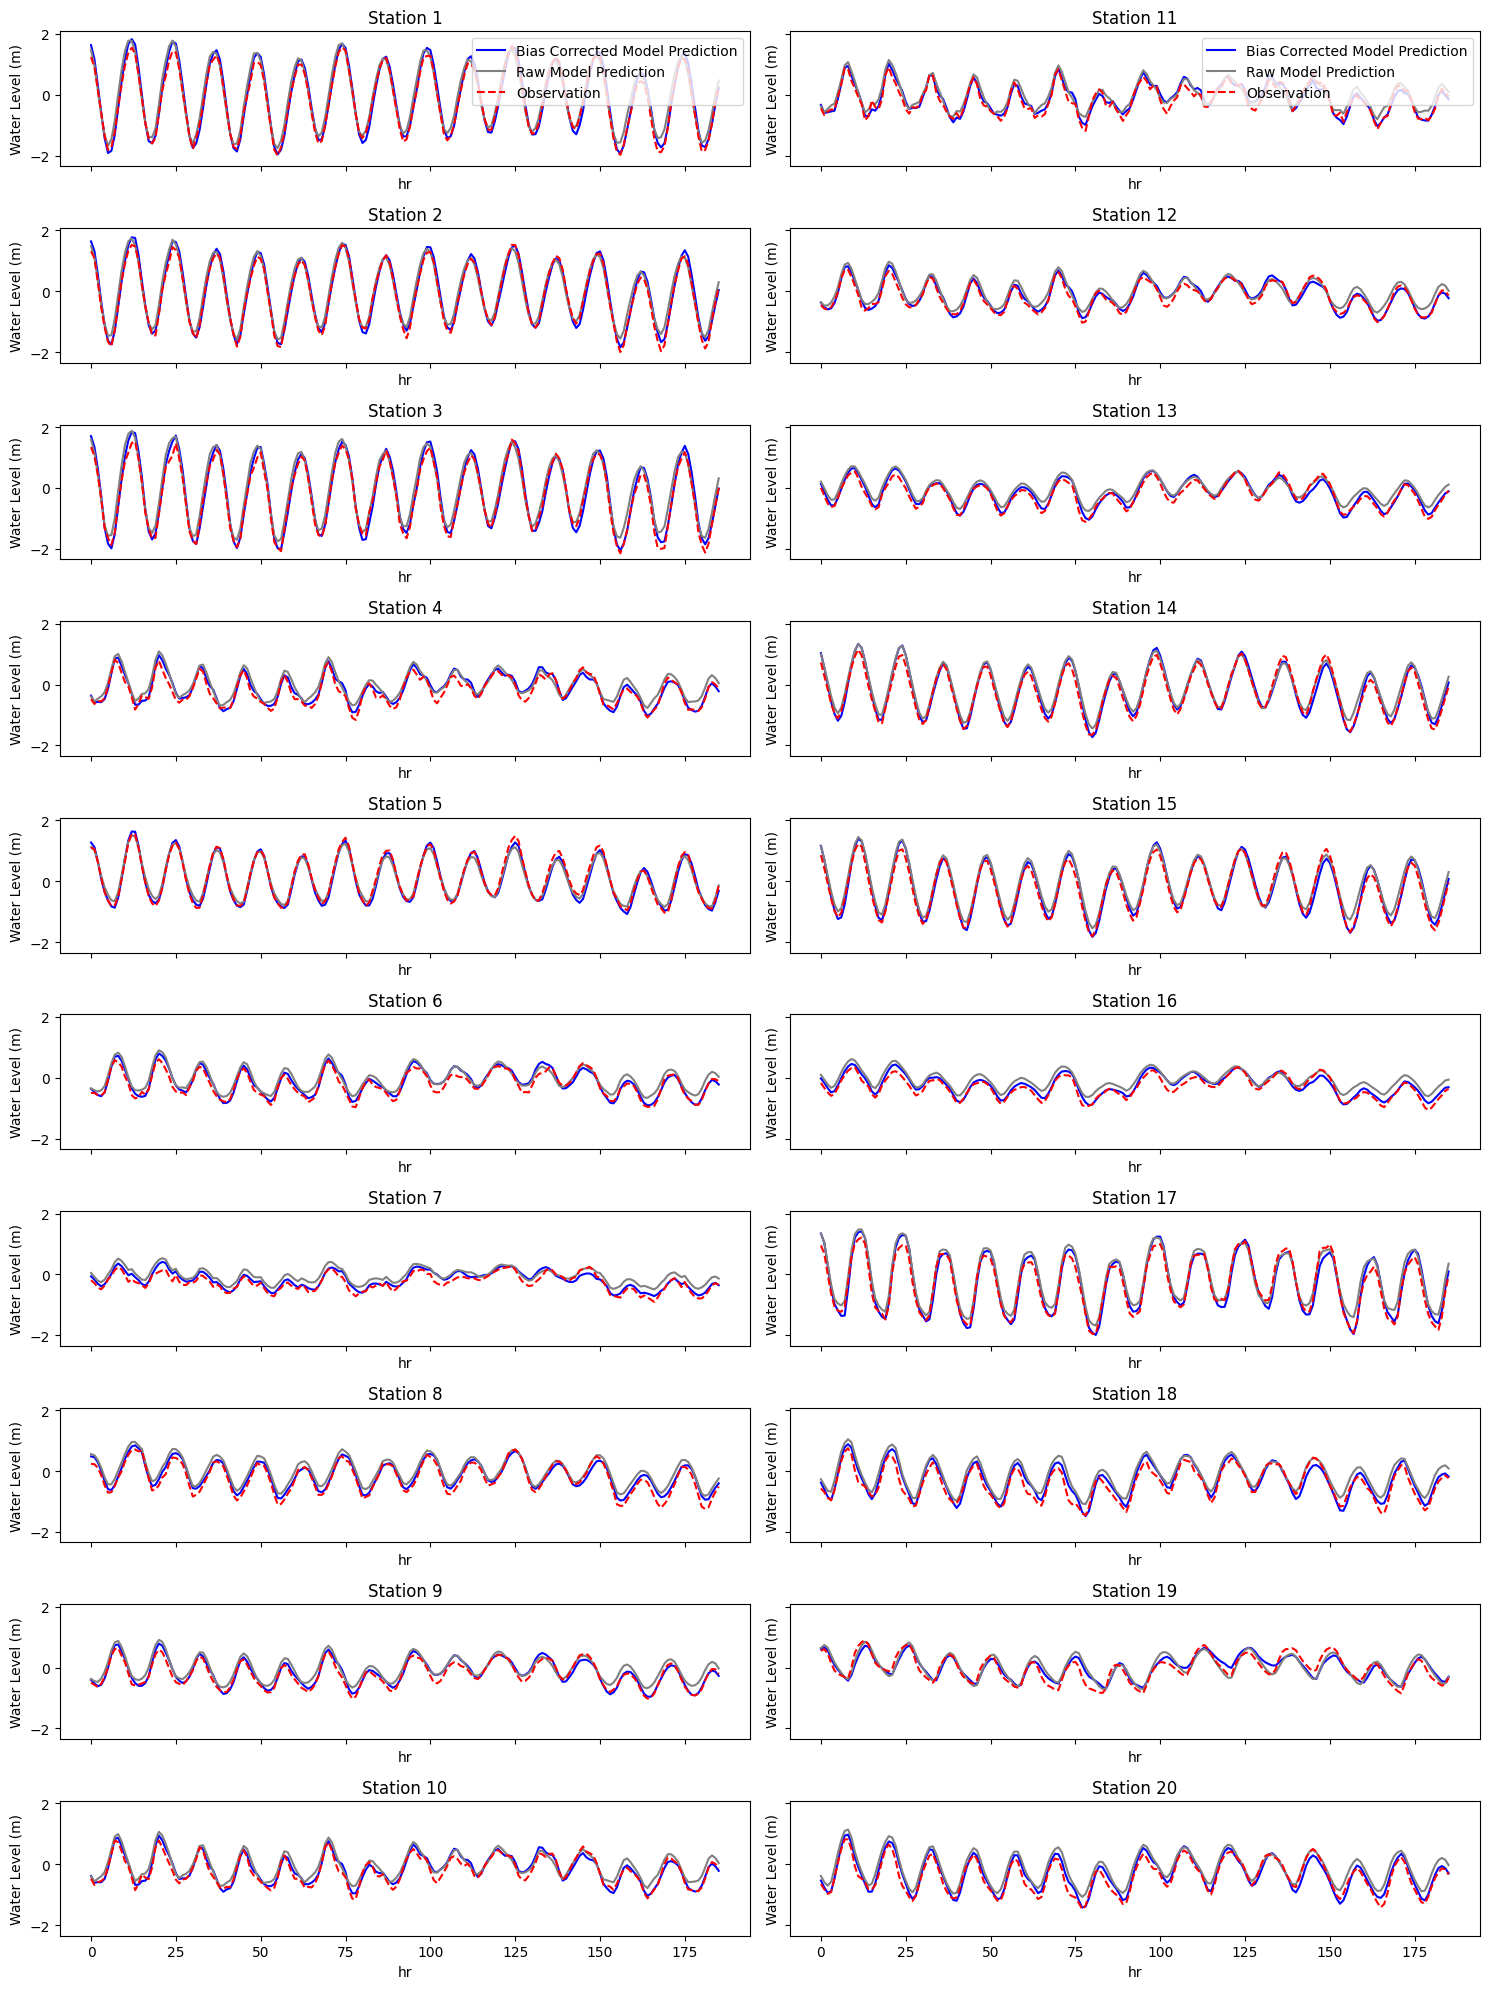

In [77]:
num_panels = 10  # Number of panels per plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(num_panels, 2, figsize=(15, 20), sharex=True, sharey=True)


output = mlp_result[1].reshape(X_20_2024_cleaned_Y.shape[0], 20, 186)
target = mlp_result[2].reshape(X_20_2024_cleaned_Y.shape[0], 20, 186)
cycle = 100
for i in range(num_panels):    
    # Left column (First set of panels)
    axs[i, 0].plot(output[cycle, i, :].cpu().numpy() + X_20_2024_cleaned_Y[cycle, i, 0, :].numpy(), 
                    label='Bias Corrected Model Prediction', color='blue')
    axs[i, 0].plot(X_20_2024_cleaned_Y[cycle, i, 0, :].numpy(), 
                    label='Raw Model Prediction', color='gray')
    axs[i, 0].plot(Y_20_2024_cleaned_Y[cycle, i, :].numpy() + X_20_2024_cleaned_Y[cycle, i, 0, :].numpy(), 
                    label='Observation', linestyle='--', color='red')
    axs[i, 0].set_title(f'Station {i+1}')

    # Right column (Second set of panels)
    axs[i, 1].plot(output[cycle, i + num_panels, :].cpu().numpy() + X_20_2024_cleaned_Y[cycle, i + num_panels, 0, :].numpy(), 
                    label='Bias Corrected Model Prediction', color='blue')
    axs[i, 1].plot(X_20_2024_cleaned_Y[cycle, i + num_panels, 0, :].numpy(), 
                    label='Raw Model Prediction', color='gray')
    axs[i, 1].plot(Y_20_2024_cleaned_Y[cycle, i + num_panels, :].numpy() + X_20_2024_cleaned_Y[cycle, i + num_panels, 0, :].numpy(), 
                    label='Observation', linestyle='--', color='red')
    axs[i, 1].set_title(f'Station {num_panels + i + 1}')

# Add legends only to the first row to avoid repetition
axs[0, 0].legend(loc='upper right')
axs[0, 1].legend(loc='upper right')

# Axis labels
for ax_row in axs:
    for ax in ax_row:
        ax.set_xlabel('hr')
        ax.set_ylabel('Water Level (m)')

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

In [78]:
Test_p = output.cpu().numpy()+X_20_2024_cleaned_Y[:,:,0,:].numpy()

In [79]:
Test_r = X_20_2024_cleaned_Y[:,:,0,:].numpy()

In [80]:
Test_t = Y_20_2024_cleaned_Y.numpy()+X_20_2024_cleaned_Y[:,:,0,:].numpy()

In [81]:
np.save("Test_prediction_utc.npy", Test_p)

In [82]:
np.save("Test_target_utc.npy", Test_t)

In [83]:
np.save("Test_raw_utc.npy", Test_r)

In [84]:
np.save("Test_date_utc.npy", time_npy_2024_cleaned_Y)